# Tunnel Squeezing Classification Using Machine Learning

## Problem Statement

**Tunnel squeezing** is a time-dependent deformation that occurs when weak rock under high stress flows into the tunnel opening. This is a critical hazard in underground construction, particularly in Himalayan geology, and can cause:
- Equipment entrapment (TBM jamming)
- Construction delays
- Structural damage

### Classification Objective

This notebook builds a **Support Vector Machine (SVM)** classifier to predict squeezing severity based on geological and geometrical parameters:

| Class | Description | Strain (ε) | Engineering Implication |
|-------|-------------|------------|-------------------------|
| **1** | Non-squeezing | < 1% | Normal excavation |
| **2** | Minor squeezing | 1% - 2.5% | Moderate support needed |
| **3** | Severe/Extreme | ≥ 2.5% | Heavy support, risk of collapse |

### Why Machine Learning?

Traditional empirical methods (e.g., Singh, Barla, Hoek criteria) provide useful thresholds but don't capture complex feature interactions. ML can:
- Learn non-linear relationships between features
- Handle multi-dimensional decision boundaries
- Provide probabilistic predictions for risk assessment

---

## 1. Setup and Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, balanced_accuracy_score, f1_score
)

# Settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

import warnings
warnings.filterwarnings('ignore')

print("Setup complete.")

Setup complete.


---
## 2. Data Loading and Cleaning

In [2]:
# Load dataset
df = pd.read_csv('data/raw/tunnel.csv')

# Remove non-informative index column
if 'No' in df.columns:
    df = df.drop(columns=['No'])

# Display basic info
print(f"Dataset shape: {df.shape[0]} samples, {df.shape[1]} features")
df.head()

Dataset shape: 117 samples, 6 features


,D (m),H(m),Q,K(MPa),ε (%),Class
0,6.0,150.0,0.4,26.19,0.42,1
1,6.0,200.0,0.4,20.00,0.75,1
2,5.8,350.0,0.5,2.53,7.90,3
3,4.8,225.0,3.6,1000.00,0.06,1
4,4.8,340.0,1.8,500.00,0.40,1


In [3]:
# Data quality check
# K(MPa) = 0 is physically invalid for rock mass stiffness
invalid_rows = df[df['K(MPa)'] <= 0]
print(f"Rows with invalid K(MPa) <= 0: {len(invalid_rows)}")

# Remove invalid rows
df_clean = df[df['K(MPa)'] > 0].copy()
print(f"Clean dataset: {len(df_clean)} samples")

Rows with invalid K(MPa) <= 0: 3
Clean dataset: 114 samples


### Dataset Characteristics

> **Note on Dataset Size**: With ~115 samples, this is a small dataset. Results should be interpreted with caution, and the model should be validated on new data before operational use.

### Feature Descriptions

| Feature | Description | Engineering Significance |
|---------|-------------|-------------------------|
| **D (m)** | Tunnel diameter | Larger diameter = more exposed surface, higher deformation potential |
| **H (m)** | Overburden depth | Depth correlates with in-situ stress (σ ≈ γH) |
| **Q** | Rock mass quality index | Lower Q = weaker rock, more prone to squeezing |
| **K (MPa)** | Rock mass stiffness | Lower K = more deformable rock |
| **ε (%)** | Measured strain | Target variable basis (used to define classes) |

---
## 3. Exploratory Data Analysis

In [4]:
# Basic statistics
df_clean.describe().round(2)

,D (m),H(m),Q,K(MPa),ε (%),Class
count,114.00,114.00,114.00,114.00,114.00,114.00
mean,6.38,385.39,0.56,384.26,4.03,2.26
std,2.38,205.86,1.64,718.03,5.50,0.85
min,2.50,52.00,0.00,2.53,0.02,1.00
25%,4.60,225.00,0.02,9.81,0.78,1.00
50%,5.80,331.00,0.06,26.20,2.61,3.00
75%,8.70,580.00,0.33,649.50,4.56,3.00
max,13.00,850.00,15.00,5324.00,36.73,3.00


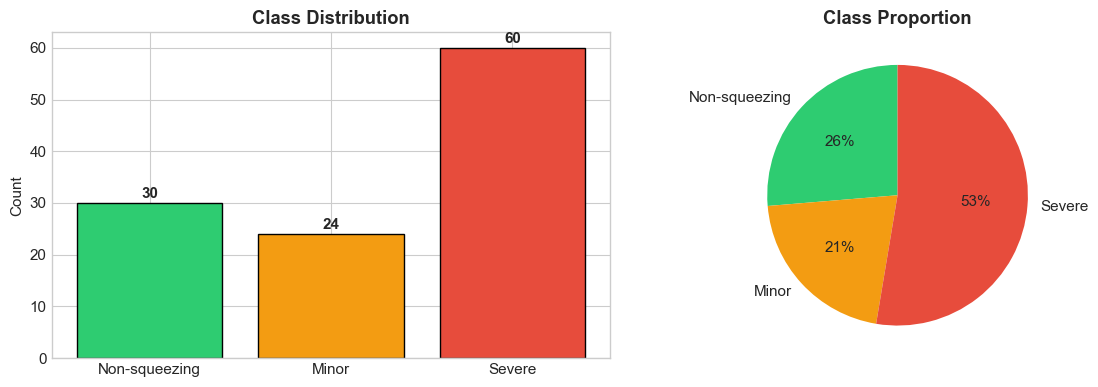


⚠️ Class Imbalance: Class 2 (Minor) is underrepresented.
   This makes Minor squeezing harder to predict accurately.


In [5]:
# Class distribution
class_counts = df_clean['Class'].value_counts().sort_index()
class_labels = {1: 'Non-squeezing', 2: 'Minor', 3: 'Severe'}
colors = ['#2ecc71', '#f39c12', '#e74c3c']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
bars = axes[0].bar([class_labels[i] for i in class_counts.index], 
                    class_counts.values, color=colors, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution', fontweight='bold')
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 str(count), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=[class_labels[i] for i in class_counts.index],
            colors=colors, autopct='%1.0f%%', startangle=90)
axes[1].set_title('Class Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ Class Imbalance: Class 2 (Minor) is underrepresented.")
print("   This makes Minor squeezing harder to predict accurately.")

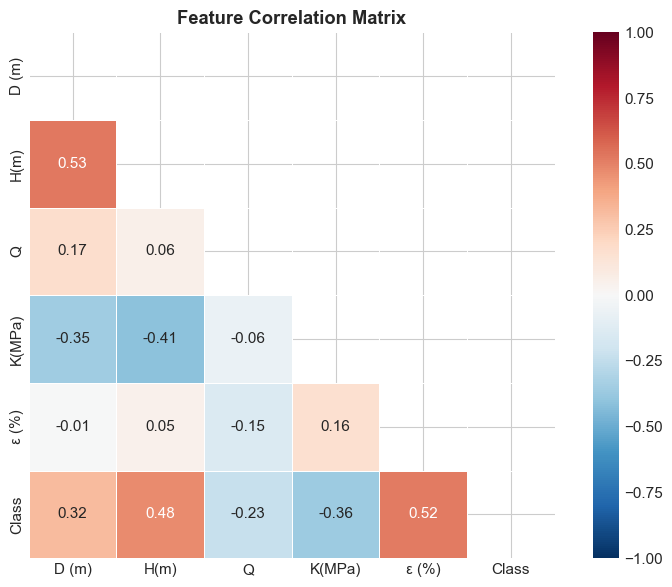

Key observations:
• Strain (ε) negatively correlates with K (stiffer rock = less deformation)
• Q and K show positive correlation (better quality rock is stiffer)


In [6]:
# Correlation heatmap
features = ['D (m)', 'H(m)', 'Q', 'K(MPa)', 'ε (%)', 'Class']
corr = df_clean[features].corr()

plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt='.2f', 
            mask=mask, vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

print("Key observations:")
print("• Strain (ε) negatively correlates with K (stiffer rock = less deformation)")
print("• Q and K show positive correlation (better quality rock is stiffer)")

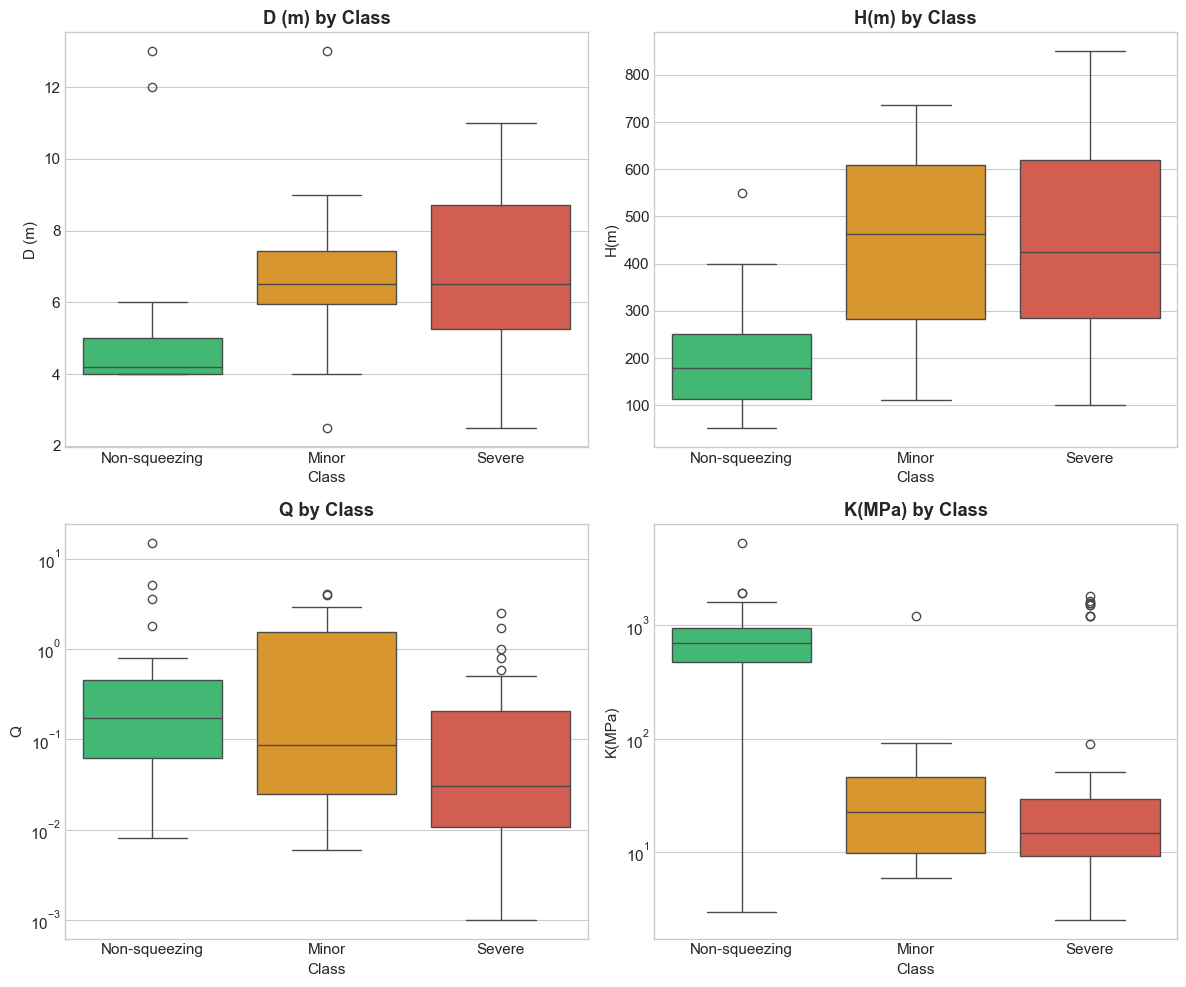

Engineering insights:
• Severe squeezing (Class 3) occurs at higher depths (H) and lower rock quality (Q)
• Non-squeezing conditions have higher K values (stiffer rock)


In [7]:
# Feature distributions by class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plot_features = ['D (m)', 'H(m)', 'Q', 'K(MPa)']

for ax, feat in zip(axes.flat, plot_features):
    sns.boxplot(x='Class', y=feat, data=df_clean, ax=ax, palette=colors)
    ax.set_xticklabels(['Non-squeezing', 'Minor', 'Severe'])
    ax.set_title(f'{feat} by Class', fontweight='bold')
    
    # Use log scale for Q and K due to wide range
    if feat in ['Q', 'K(MPa)']:
        ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("Engineering insights:")
print("• Severe squeezing (Class 3) occurs at higher depths (H) and lower rock quality (Q)")
print("• Non-squeezing conditions have higher K values (stiffer rock)")

---
## 4. Data Preparation

**Key Practice**: We split data BEFORE any preprocessing to prevent data leakage.

In [8]:
# Define features and target
X = df_clean[['D (m)', 'H(m)', 'Q', 'K(MPa)']].values
y = df_clean['Class'].values

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {len(y_train)} samples")
print(f"Test set: {len(y_test)} samples")
print(f"\nClass distribution in test set:")
for cls in [1, 2, 3]:
    print(f"  Class {cls}: {(y_test == cls).sum()} samples")

Training set: 91 samples
Test set: 23 samples

Class distribution in test set:
  Class 1: 6 samples
  Class 2: 5 samples
  Class 3: 12 samples


---
## 5. Model Building

### Why Pipeline?

Using `sklearn.pipeline.Pipeline` ensures:
1. **No data leakage**: Scaler is fitted only on training data during each CV fold
2. **Clean code**: All preprocessing and model in one object
3. **Reproducibility**: Easy to save and deploy

In [9]:
# Create pipeline: Scaling -> SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=RANDOM_STATE))
])

# Hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 0.01, 0.1],
    'svm__kernel': ['rbf']
}

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Grid Search
print("Running GridSearchCV with Stratified 5-Fold CV...")
grid_search = GridSearchCV(
    pipeline, param_grid, 
    cv=cv, 
    scoring='f1_macro',  # Robust metric for imbalanced data
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1-macro: {grid_search.best_score_:.3f}")

Running GridSearchCV with Stratified 5-Fold CV...



Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV F1-macro: 0.618


In [10]:
# Cross-validation score distribution
cv_results = cross_val_score(
    grid_search.best_estimator_, X_train, y_train, 
    cv=cv, scoring='f1_macro'
)

print("Cross-Validation Results (F1-macro):")
print(f"  Mean: {cv_results.mean():.3f}")
print(f"  Std:  {cv_results.std():.3f}")
print(f"  Folds: {cv_results.round(3)}")

Cross-Validation Results (F1-macro):
  Mean: 0.618
  Std:  0.059
  Folds: [0.65  0.539 0.557 0.658 0.686]


---
## 6. Model Evaluation

In [11]:
# Best model predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("=" * 50)
print("TEST SET PERFORMANCE")
print("=" * 50)
print(f"Accuracy:          {acc:.1%}")
print(f"Balanced Accuracy: {bal_acc:.1%}")
print(f"F1-score (macro):  {f1_macro:.3f}")
print("=" * 50)

TEST SET PERFORMANCE
Accuracy:          73.9%
Balanced Accuracy: 65.0%
F1-score (macro):  0.651


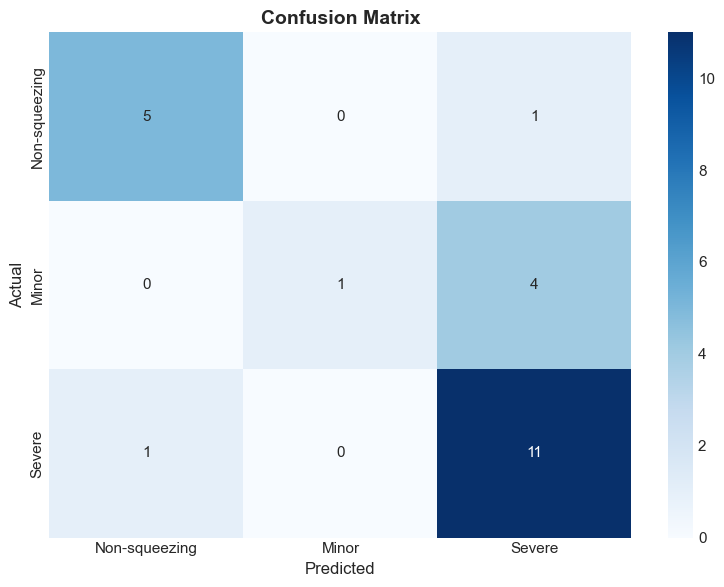


Classification Report:
               precision    recall  f1-score   support

Non-squeezing       0.83      0.83      0.83         6
        Minor       1.00      0.20      0.33         5
       Severe       0.69      0.92      0.79        12

     accuracy                           0.74        23
    macro avg       0.84      0.65      0.65        23
 weighted avg       0.79      0.74      0.70        23



In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Non-squeezing', 'Minor', 'Severe']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Per-class metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

### Understanding Misclassifications

**Why is Class 2 (Minor squeezing) harder to classify?**

1. **Transition zone**: Minor squeezing sits between stable and severe conditions
2. **Fewer samples**: Class imbalance reduces learning signal
3. **Overlapping features**: Feature values overlap with both Class 1 and Class 3

**Engineering Impact of Errors:**

| Error Type | Actual → Predicted | Consequence |
|------------|-------------------|-------------|
| **False Negative** | Severe → Non-squeezing | **Dangerous**: Underestimating risk can lead to collapse |
| **False Positive** | Non-squeezing → Severe | **Costly**: Over-support increases construction cost |

> **Recommendation**: In practice, err on the side of caution. Predicting a higher class than actual is safer than underestimating squeezing risk.

---
## 7. Engineering Interpretation

### What the Model Learned

The SVM classifier has learned decision boundaries in the 4D feature space (D, H, Q, K):

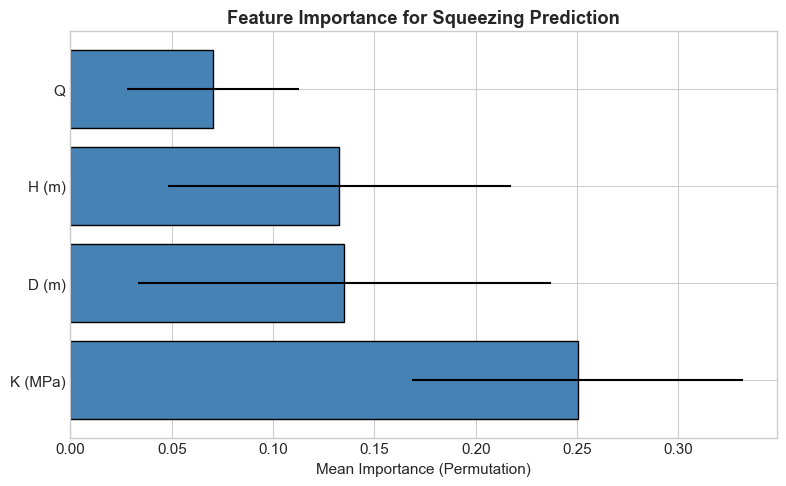

Interpretation:
• K (MPa) is the most important predictor of squeezing class


In [13]:
# Feature importance approximation using permutation
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    best_model, X_test, y_test, 
    n_repeats=30, random_state=RANDOM_STATE, scoring='f1_macro'
)

feature_names = ['D (m)', 'H (m)', 'Q', 'K (MPa)']
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(8, 5))
plt.barh(range(4), perm_importance.importances_mean[sorted_idx], 
         xerr=perm_importance.importances_std[sorted_idx],
         color='steelblue', edgecolor='black')
plt.yticks(range(4), [feature_names[i] for i in sorted_idx])
plt.xlabel('Mean Importance (Permutation)')
plt.title('Feature Importance for Squeezing Prediction', fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
top_feature = feature_names[sorted_idx[0]]
print(f"• {top_feature} is the most important predictor of squeezing class")

### Physical Meaning

The model's predictions align with geotechnical understanding:

| Feature | High Value Tends Toward | Physical Reason |
|---------|------------------------|------------------|
| **H (depth)** | Severe squeezing | Higher overburden = higher confining stress |
| **Q (quality)** | Non-squeezing | Better rock resists deformation |
| **K (stiffness)** | Non-squeezing | Stiffer rock has lower strain response |
| **D (diameter)** | Varies | Larger openings expose more weak rock, but also redistribute stress |

### Practical Application

This model can assist tunnel engineers by:
1. **Pre-construction screening**: Identify high-risk zones along alignment
2. **Support design**: Prioritize resources for predicted severe zones
3. **Risk assessment**: Provide probabilistic estimates for project planning

> **Important**: This model should complement, not replace, geological investigation and engineering judgment.

---
## 8. Model Export

In [14]:
import joblib

# Save the complete pipeline (scaler + model)
joblib.dump(best_model, 'models/svm_squeezing_pipeline.pkl')
print("Model saved to: models/svm_squeezing_pipeline.pkl")

# Usage example
print("\n--- Prediction Example ---")
sample = [[6.0, 350, 0.5, 25]]  # D=6m, H=350m, Q=0.5, K=25 MPa
pred_class = best_model.predict(sample)[0]
pred_proba = best_model.predict_proba(sample)[0]

print(f"Input: D=6m, H=350m, Q=0.5, K=25 MPa")
print(f"Predicted Class: {pred_class} ({class_names[pred_class-1]})")
print(f"Class Probabilities: {dict(zip(class_names, pred_proba.round(3)))}")

Model saved to: models/svm_squeezing_pipeline.pkl

--- Prediction Example ---
Input: D=6m, H=350m, Q=0.5, K=25 MPa
Predicted Class: 3 (Severe)
Class Probabilities: {'Non-squeezing': np.float64(0.336), 'Minor': np.float64(0.239), 'Severe': np.float64(0.425)}


---
## 9. Limitations and Future Work

### Limitations

1. **Small dataset**: 115 samples limits generalization. More data would improve reliability.
2. **Class imbalance**: Minor squeezing (Class 2) is underrepresented, affecting recall.
3. **Feature set**: Other factors (support timing, rock anisotropy, water) are not included.
4. **Geographic scope**: Training data may not transfer to geologically different regions.

### Future Work

1. **Data collection**: Expand dataset with more tunnel case studies
2. **Feature engineering**: Add derived features (e.g., H/D ratio, stress-strength ratio)
3. **Ensemble methods**: Compare with Random Forest, XGBoost
4. **Probability calibration**: Improve reliability of probability estimates
5. **Explainability**: Add SHAP analysis for individual prediction explanations

---

**Author**: Sudip Adhikari  
**Date**: January 2026  
**License**: MIT